In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
from tqdm import tqdm

from GA_params_class.GeneticAlgorithm import GeneticAlgorithm
from function_module import *
from divergence_module import *

In [2]:
cnn_model_path = '../../Models/CNN_6_1_2.keras'
masked_sequence = 'AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTGGGCGGGAAGACAACTAGGGG'
target_expressions = [0, 0.5, 1]
precision = None
verbose = 0
lineages = 10
test_cases = 10

# To pass into the divergence test function
kwargs = {
    'cnn_model_path': cnn_model_path,
    'masked_sequence': masked_sequence,
    'target_expressions': target_expressions,
    'precision': precision,
    'verbose': verbose,
}

In [3]:
# Vary diversity_alpha

range_diversity_alpha = np.linspace(0, 1, test_cases, dtype=float)

total_combinations = len(target_expressions) * len(range_diversity_alpha) * lineages
progress_bar = tqdm(total=total_combinations, desc="Processing combinations", position=0)
initial_time = time.time()

current_combination = 0
results = []

for target_expression in target_expressions:
    for diversity_alpha in range_diversity_alpha:
        ga = GeneticAlgorithm(
            cnn_model_path=cnn_model_path,
            masked_sequence=masked_sequence,
            target_expression=target_expression,
            precision=precision,
            verbose=verbose,
            diversity_alpha=diversity_alpha, # Dependant variable
        )
        for _ in range(lineages):
            current_combination += 1

            # Time the run
            start_time = time.time()
            best_sequences, best_predictions = ga.run()
            end_time = time.time()

            # Record the results
            for sequence, prediction in zip(best_sequences, best_predictions):
                results.append({
                    'target_expression': target_expression,
                    'diversity_alpha': diversity_alpha,
                    'error': abs(prediction - target_expression),
                    'run_time': (end_time - start_time) / lineages
                })
        
            # Update progress bar
            progress_bar.update(1)
            elapsed_time = time.time() - initial_time
            progress_bar.set_postfix({
                "Elapsed": format_time(elapsed_time),
                "ETA": format_time(((elapsed_time / current_combination) * (total_combinations - current_combination)))
            })

# Close progress bar
progress_bar.close()

results_df = pd.DataFrame(results)
results_df.to_csv('Data/MOGA/diversity_alpha.csv', index=False)

Processing combinations:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Instructions for updating:
Use tf.identity with explicit device placement instead.


Processing combinations: 100%|██████████| 300/300 [14:57<00:00,  2.99s/it, Elapsed=14.97min, ETA=0.00s]  


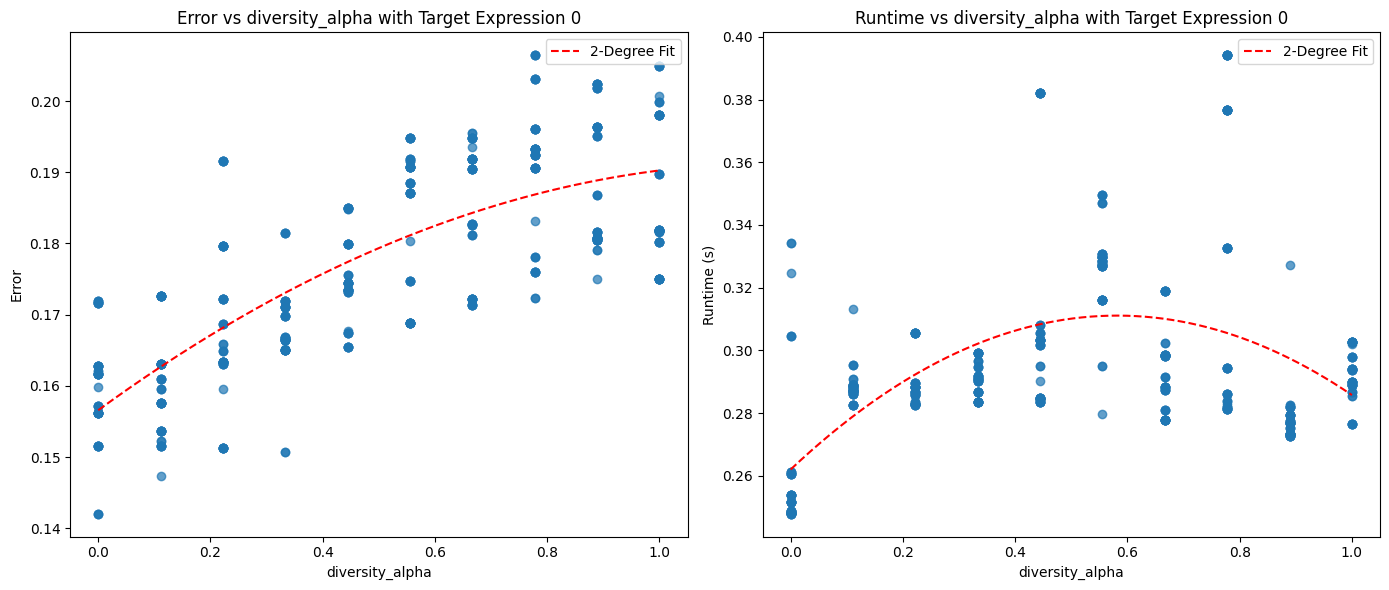

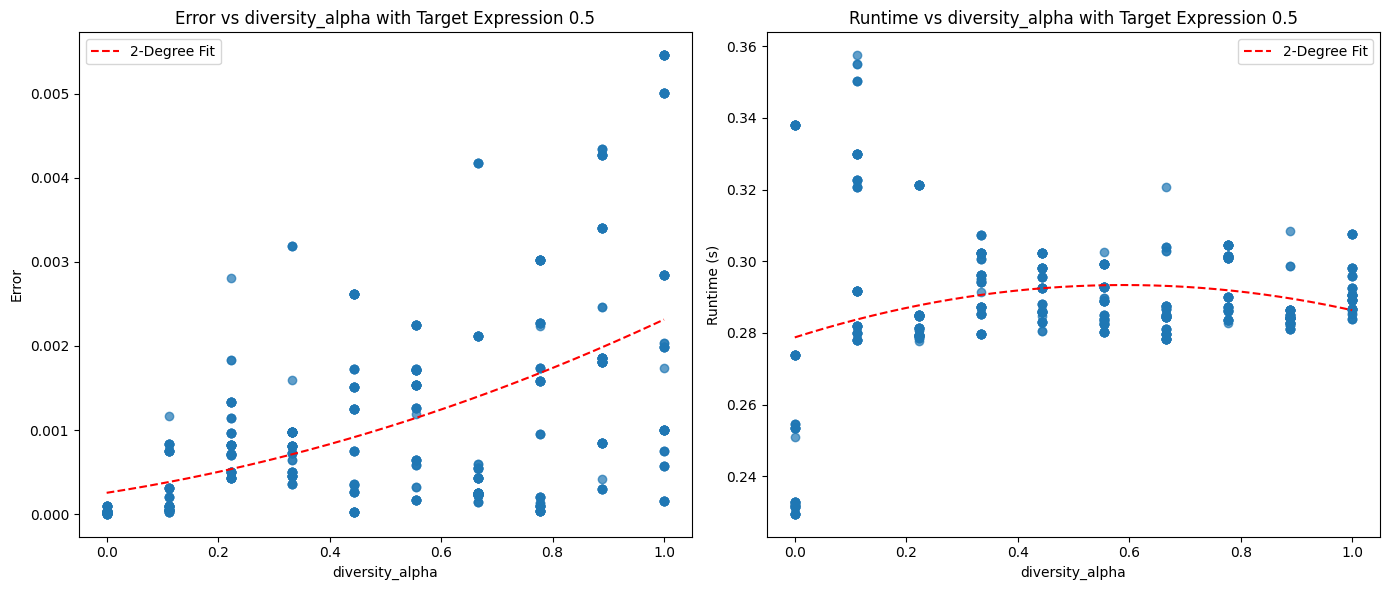

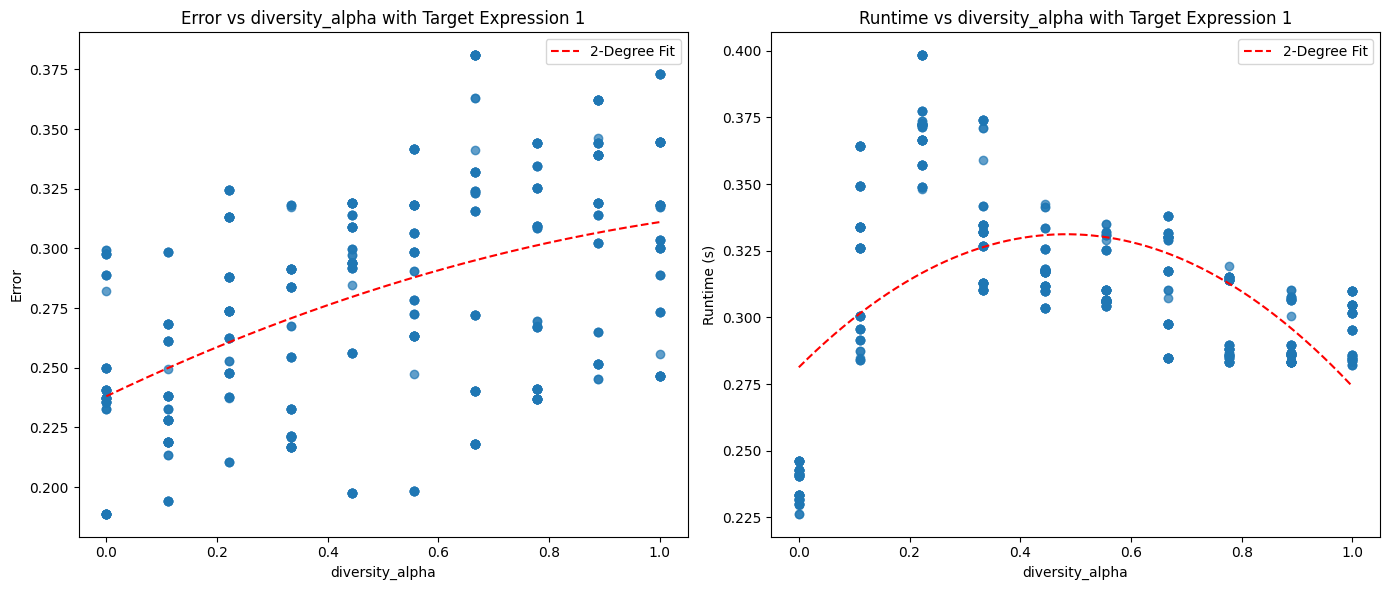

In [4]:
for target_expression in target_expressions:
    filtered_df = results_df[results_df['target_expression'] == target_expression]
    scatter_plot(filtered_df, target_expression, 'diversity_alpha', polynomial_degree=2)

In [5]:
lineage_divergence_alpha_range = np.linspace(0.1, 1, test_cases, dtype=float)
lineage_range = np.linspace(1, 10, test_cases, dtype=int)

results_df, infill_histories = test_divergence(lineage_divergence_alpha_range, lineage_range=lineage_range, **kwargs)

Processing combinations: 100%|██████████| 300/300 [1:10:11<00:00, 14.04s/it, Elapsed=70.18min, ETA=0.00s]  


In [3]:
# load results
results_df = pd.read_csv('Data/MOGA/10_lineages_results_1.csv')

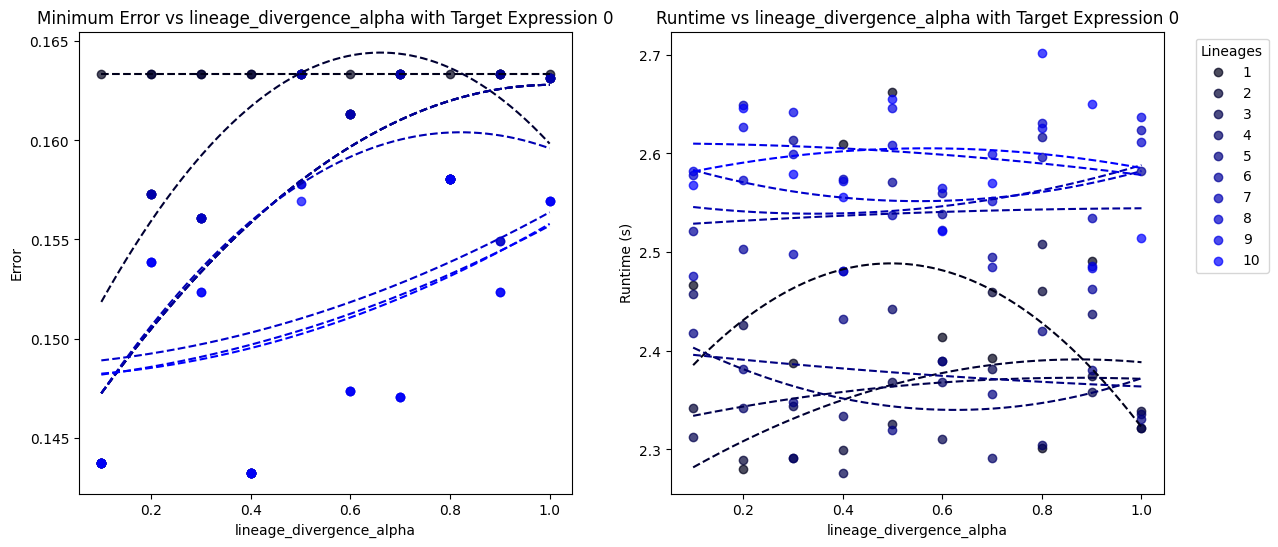

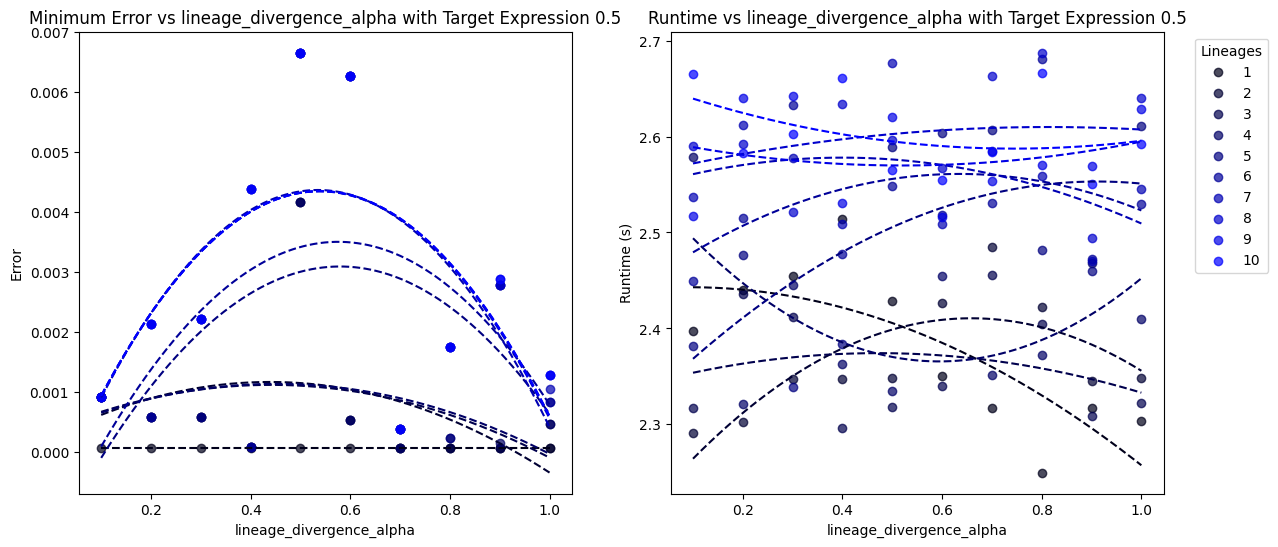

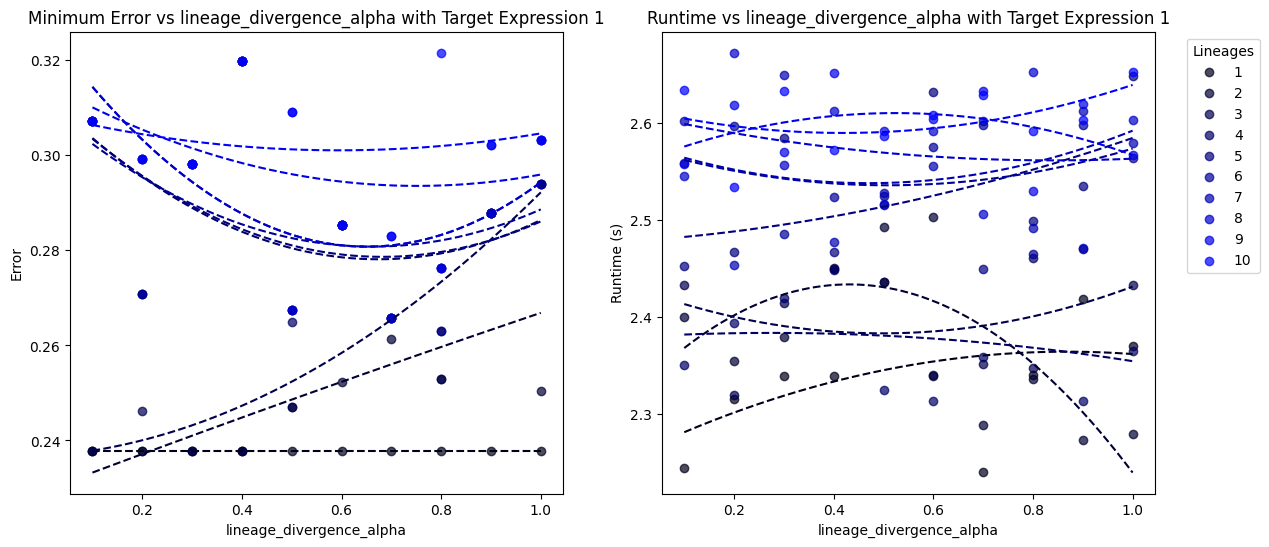

In [4]:
# Showing the distribution of results for each target expression, number of lineages and lineage divergence alpha

for target_expression in target_expressions:
    filter_df = results_df[results_df['target_expression'] == target_expression]
    divergence_scatter_plot(filter_df, target_expression, 'lineage_divergence_alpha', polynomial_degree=2)

In [ ]:
# For target_expression 0
target_expression = 0

for lineages in lineage_range:
    data = []
    for lineage_divergence_alpha in lineage_divergence_alpha_range:
        infill_history = infill_histories[lineages][target_expression][lineage_divergence_alpha]
        data.append(calculate_intra_lineage_hamm(infill_history))
    plot_intra_hamm_comparison(data, lineage_divergence_alpha_range)